In [58]:
import numpy as np
import pandas as pd
import matplotlib as mp
import statsmodels.api as sm

from statsmodels.sandbox.regression.gmm import GMM


In [59]:
data = pd.read_csv('C:/Users/User/Desktop/midterm_partone.csv')

In [60]:
data.head()

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio
0,1,0.870332,1.795946,0.115846,0.208053,1.672527,0.255171,0.473317
1,1,-0.047347,1.395501,0.436967,0.609788,1.637261,0.221763,0.489967
2,1,0.001176,1.664563,0.541016,0.900555,1.640619,0.189141,0.374269
3,1,-0.901200,1.605738,0.539399,0.866133,1.436221,0.131944,0.224399
4,1,-0.176353,1.591451,0.539938,0.859285,1.433140,0.183095,0.213446


PART 1

In [61]:
y_vals = np.array(data["Stock Change"])
x_vals = np.array(data[["Inventory Turnover", "Operating Profit", "Interaction Effect"]])
iv_vals = np.array(data[["Current Ratio", "Quick Ratio", "Debt Asset Ratio"]])


In [62]:

class gmm_with_vector_bias(GMM):
    def momcond(self, params):
        # Unpack parameters
        p0, p1, p2, p3, p4 = params  # Include p4 as the additional parameter as delta
        endog = self.endog
        exog = self.exog
        inst = self.instrument
        
        residuals = endog - (p0 + p1 * exog[:, 0] + p2 * exog[:, 1] + p3 * exog[:, 2])
        
        #enfogenous variable moment expression
        error0 = residuals
        error1 = residuals * exog[:, 1] 
        error2 = residuals * exog[:, 2] 

        #instrumental-variable moment expression
        error3 = residuals * inst[:, 0] - p4
        error4 = residuals * inst[:, 1] - p4
        error5 = residuals * inst[:, 2] - p4
        
        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g

beta_with_p4 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) 

# Fit the modified GMM model
res = gmm_with_vector_bias(endog=y_vals, exog=x_vals, instrument=iv_vals, k_moms=6, k_params=5).fit(beta_with_p4)
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.000345
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000346
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000346
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
                          gmm_with_vector_bias Results                          
Dep. Variable:                        y   Hansen J:                       0.5862
Model:             gmm_with_vector_bias   Prob (Hansen J):                 0.444
Method:                             GMM                                   



Since 𝛿 has a high p-value (1.000), we would conclude that there is no statistically significant bias as claimed by the industry expert. This outcome suggests that the hypothesis of bias in the moment conditions may not be supported by the data.

PART 2

In [63]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import classification_report,f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
df = pd.read_csv('C:/Users/User/Desktop/midterm_parttwo.csv')

In [66]:
df.head()

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
0,1,Low,No dependent,Very low,Very low,Married,Positive
1,2,Low,No dependent,Very low,Very low,Single,Positive
2,1,Low,No dependent,Very low,Very low,Single,Positive
3,3,Low,No dependent,Very low,Very low,Married,Positive
4,3,Low,No dependent,Very low,Very low,Single,Negative


In [67]:
categorical_columns = ['Requested Credit Amount','Number of Dependents', 'Monthly Income', 'Monthly Expense','Marital Status']

label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [68]:
df['Credit Rating'] = df['Credit Rating'].replace({"Positive": 1 , "Negative": 0})

In [69]:
df.describe()

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
count,8081.000000,8081.000000,8081.000000,8081.000000,8081.000000,8081.000000,8081.000000
mean,2.608588,1.308749,0.998886,2.332756,3.342408,0.527781,0.858186
std,1.571835,0.480907,0.945481,1.441955,1.233483,0.871298,0.348881
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,4.000000,0.000000,1.000000
50%,3.000000,1.000000,1.000000,2.000000,4.000000,0.000000,1.000000
75%,3.000000,2.000000,2.000000,4.000000,4.000000,2.000000,1.000000
max,7.000000,2.000000,2.000000,4.000000,4.000000,2.000000,1.000000


In [70]:
df.columns

Index(['Years of Education after High School', 'Requested Credit Amount',
       'Number of Dependents', 'Monthly Income', 'Monthly Expense',
       'Marital Status', 'Credit Rating'],
      dtype='object')

In [71]:
scaler = MinMaxScaler()

columns_to_scale = df.columns.difference(['Credit Rating'])
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [72]:
X = df.drop(columns=['Credit Rating'])
y = df['Credit Rating']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=42)

In [73]:
logreg = LogisticRegression()

In [74]:
lr_model = logreg.fit(X_train,y_train)

pred_log = lr_model.predict(X_test)

In [75]:
f1_score(y_test, pred_log, average= 'weighted')

0.7913092006137623

In [76]:
print(f'Logistic Regression F1 Score: {f1_score(y_test, pred_log)}')
print(f'Logistic Regression Precision Score: {precision_score(y_test, pred_log)}')
print(f'Logistic Regression Recall Score: {recall_score(y_test, pred_log)}')

Logistic Regression F1 Score: 0.9231179213857429
Logistic Regression Precision Score: 0.8572135609997525
Logistic Regression Recall Score: 1.0


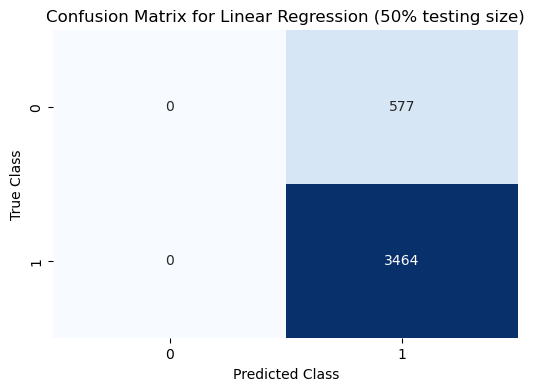

In [77]:
#Confusion Matrix
cm_log = confusion_matrix(y_test, pred_log)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix for Linear Regression (50% testing size)")
plt.show()

part 2 - b

In [79]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

probs = lr_model.predict_proba(X_test)[:, 1] 

threshold = np.percentile(probs, 85)
print(threshold)

0.8776216960738153


In [80]:
predictions = [1 if prob > threshold else 0 for prob in probs]

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("Updated Precision:", precision)
print("Updated Recall:", recall)
print("Updated F1 Score:", f1)

Updated Precision: 0.8839137645107794
Updated Recall: 0.15386836027713627
Updated F1 Score: 0.2621096631423654


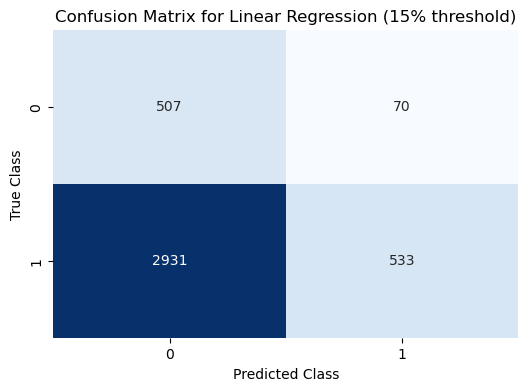

In [81]:
cm_log1 = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix for Linear Regression (15% threshold)")
plt.show()